# 회귀분석

## 검증하고자 하는 것 : 맛집 프로그램별 SNS채널(네이버 블로그)에 미치는 영향력

### 분석계획 
### 1. 독립변수에 방송 프로그램 외 변수들을 추가하면서 R^2가 높아지는지 확인 & R^2가 가장 높은 회귀식 도출
### 2. 방송 프로그램별 회귀식을 만들어 포스팅 증가에 가장 영향을 미치는 요인 찾아보기
### 3. 2017년 데이터(train set)로 회귀식을 만든 후, 2018년 데이터(test set)로 예측해보고 정확도 확인

In [1]:
import pandas as pd
import numpy as np

In [2]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('raw_data/reg.csv')

In [29]:
df.head()

,식당,방송,방영전,방영후,증가,서울,방영월
0,136생고기,생생정보,4,45,41,0,3
1,3일한우국밥,생생정보,35,51,16,1,3
2,가람떡갈비,맛있는녀석들,21,50,29,1,1
3,가마솥 족발,생생정보,31,106,75,0,3
4,가마솥손두부,생생정보,11,45,34,1,4


## X : 방송(생생정보, 맛있는녀석들, 수요미식회),  방영전 포스팅 수, 서울(서울:1, 서울 외 지역:0), 계절(봄, 여름, 가을, 겨울)

## Y : 방영 후 포스팅 증감 수

## 1. 데이터 전처리 : 더미변수 만들기

In [30]:
#봄(3-5월), 여름(6-8월), 가을(9-11월), 겨울(12-2월)
df.loc[(df['방영월']>2)&(df['방영월']<6), '계절'] = '봄'
df.loc[(df['방영월']>5)&(df['방영월']<9), '계절'] = '여름'
df.loc[(df['방영월']>8)&(df['방영월']<12), '계절'] = '가을'
df.loc[(df['방영월']<3)|(df['방영월']==12), '계절'] = '겨울'

In [31]:
df.head()

,식당,방송,방영전,방영후,증가,서울,방영월,계절
0,136생고기,생생정보,4,45,41,0,3,봄
1,3일한우국밥,생생정보,35,51,16,1,3,봄
2,가람떡갈비,맛있는녀석들,21,50,29,1,1,겨울
3,가마솥 족발,생생정보,31,106,75,0,3,봄
4,가마솥손두부,생생정보,11,45,34,1,4,봄


In [32]:
df['서울'] = df['서울'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 8 columns):
식당     317 non-null object
방송     317 non-null object
방영전    317 non-null int64
방영후    317 non-null int64
증가     317 non-null int64
서울     317 non-null category
방영월    317 non-null int64
계절     317 non-null object
dtypes: category(1), int64(4), object(3)
memory usage: 17.8+ KB


In [33]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

In [34]:
dummy_columns = ['방송', '서울', '계절']

reg = dummy_data(df, dummy_columns)
reg.head()

,식당,방영전,방영후,증가,방영월,방송_맛있는녀석들,방송_생생정보,방송_수요미식회,서울_0,서울_1,계절_가을,계절_겨울,계절_봄,계절_여름
0,136생고기,4,45,41,3,0,1,0,1,0,0,0,1,0
1,3일한우국밥,35,51,16,3,0,1,0,0,1,0,0,1,0
2,가람떡갈비,21,50,29,1,1,0,0,0,1,0,1,0,0
3,가마솥 족발,31,106,75,3,0,1,0,1,0,0,0,1,0
4,가마솥손두부,11,45,34,4,0,1,0,0,1,0,0,1,0


In [35]:
reg.describe()

,방영전,방영후,증가,방영월,방송_맛있는녀석들,방송_생생정보,방송_수요미식회,서울_0,서울_1,계절_가을,계절_겨울,계절_봄,계절_여름
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.00000,317.000000,317.000000,317.000000,317.000000,317.00000,317.000000
mean,31.479495,72.148265,40.668770,5.747634,0.318612,0.350158,0.33123,0.397476,0.602524,0.217666,0.283912,0.33123,0.167192
std,55.628376,74.439170,38.331095,3.472227,0.466675,0.477773,0.47140,0.490150,0.490150,0.413311,0.451607,0.47140,0.373738
min,0.000000,0.000000,-37.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,5.000000,31.000000,16.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,13.000000,48.000000,28.000000,5.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
75%,32.000000,92.000000,55.000000,9.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.00000,0.000000
max,504.000000,576.000000,265.000000,12.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [36]:
reg.columns

Index(['식당', '방영전', '방영후', '증가', '방영월', '방송_맛있는녀석들', '방송_생생정보', '방송_수요미식회',
       '서울_0', '서울_1', '계절_가을', '계절_겨울', '계절_봄', '계절_여름'],
      dtype='object')

In [17]:
reg.to_csv('raw_data/reg_tidy.csv', index=False)

In [37]:
reg.drop(['방송_맛있는녀석들' , '서울_0'], axis=1 ,inplace= True)
reg.head()

,식당,방영전,방영후,증가,방영월,방송_생생정보,방송_수요미식회,서울_1,계절_가을,계절_겨울,계절_봄,계절_여름
0,136생고기,4,45,41,3,1,0,0,0,0,1,0
1,3일한우국밥,35,51,16,3,1,0,1,0,0,1,0
2,가람떡갈비,21,50,29,1,0,0,1,0,1,0,0
3,가마솥 족발,31,106,75,3,1,0,0,0,0,1,0
4,가마솥손두부,11,45,34,4,1,0,1,0,0,1,0


In [38]:
reg.drop(['방영후' , '방영월'], axis=1 ,inplace= True)
reg.head()

,식당,방영전,증가,방송_생생정보,방송_수요미식회,서울_1,계절_가을,계절_겨울,계절_봄,계절_여름
0,136생고기,4,41,1,0,0,0,0,1,0
1,3일한우국밥,35,16,1,0,1,0,0,1,0
2,가람떡갈비,21,29,0,0,1,0,1,0,0
3,가마솥 족발,31,75,1,0,0,0,0,1,0
4,가마솥손두부,11,34,1,0,1,0,0,1,0


# 분석1 : 독립변수에 방송 프로그램 외 변수들을 추가하면서 R^2가 높아지는지 확인 & R^2가 가장 높은 회귀식 도출

## 기본모형 : 증가(y) ~ 방송_생생정보(x1) + 방송_수요미식회(x2) + 방영전(x3)

In [18]:
model1 = smf.ols("증가 ~ 방송_생생정보 + 방송_수요미식회 + 방영전",  data=reg).fit(cov_type='HC0')

## 1. 가정

### 1) 정규성

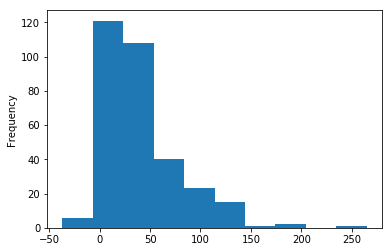

In [12]:
df['증가'].plot(kind='hist')

왼쪽으로 치우쳐 있어 변환이 필요해 보이나, 음수 값이 있어서 log변환이나 box-cox변환을 할 수 없음

Q-Q plot을 보자

Text(0.5,1,'Model1 Residuals Q-Q Plot')

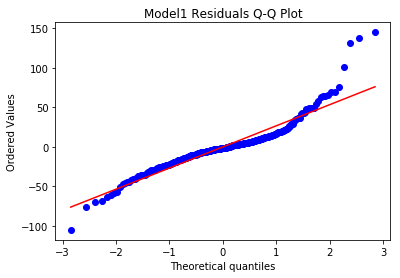

In [19]:
stats.probplot(model1.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

엄밀히 정규성을 따른다고 말하기 어렵지만, 데이터 갯수(317)가 크니 중심극한정리(CLT)에 의해 정규분포를 따른다고 가정하겠음

### 2) 등분산

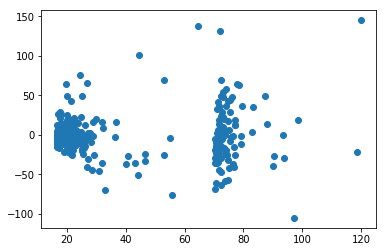

In [20]:
resid = model1.resid
plt.scatter(model1.predict(), resid)

In [21]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model1.resid, model1.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 94.66831296199325),
 ('p-value', 2.175686828965404e-20),
 ('f-value', 44.424889605049934),
 ('f p-value', 6.045953748404026e-24)]

p-value < 0.05 이므로 등분산 가정도 만족을 안 한다..

### 3) 오차의 독립성

In [22]:
statsmodels.stats.stattools.durbin_watson(model1.resid)

2.0976858727291012

2에 가까울수록 독립성 가정이 만족하는데, 2에 가까우니 독립성 가정도 만족

### 4) 다중공선성

In [39]:
reg.corr()

,방영전,증가,방송_생생정보,방송_수요미식회,서울_1,계절_가을,계절_겨울,계절_봄,계절_여름
방영전,1.000000,0.229190,-0.130168,0.005389,0.022332,0.125652,-0.077741,-0.017299,-0.023199
증가,0.229190,1.000000,-0.326284,0.638327,0.214800,-0.009617,-0.045920,0.083150,-0.038756
방송_생생정보,-0.130168,-0.326284,1.000000,-0.516600,-0.349727,0.013447,0.065792,-0.038872,-0.045340
방송_수요미식회,0.005389,0.638327,-0.516600,1.000000,0.283987,0.018599,-0.056646,0.031626,0.007989
서울_1,0.022332,0.214800,-0.349727,0.283987,1.000000,-0.071452,0.053938,-0.031021,0.052969
계절_가을,0.125652,-0.009617,0.013447,0.018599,-0.071452,1.000000,-0.332129,-0.371215,-0.236339
계절_겨울,-0.077741,-0.045920,0.065792,-0.056646,0.053938,-0.332129,1.000000,-0.443134,-0.282127
계절_봄,-0.017299,0.083150,-0.038872,0.031626,-0.031021,-0.371215,-0.443134,1.000000,-0.315328
계절_여름,-0.023199,-0.038756,-0.045340,0.007989,0.052969,-0.236339,-0.282127,-0.315328,1.000000


변수들 사이에 강한 상관관계가 보이지 않으므로 다중공선성 문제는 없다고 봐도 무방함

## 2. 회귀분석 결과

In [23]:
#model1 = smf.ols("증가 ~ 방송_생생정보 + 방송_수요미식회 + 방영전",  data=reg).fit(cov_type='HC0')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     63.42
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           4.63e-32
Time:                        11:09:53   Log-Likelihood:                -1507.5
No. Observations:                 317   AIC:                             3023.
Df Residuals:                     313   BIC:                             3038.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.6001      2.863      5.797      0.000      10.988      22.212
방송_생생정보        3.6074      2.944      1.225      0.220      -2.163       9.378
방송_수요미식회      53.6919      4.353     12.333      0.000      45.159      62.225
방영전            0.1595      0.082      1.943      0.052      -0.001       0.320
==============================================================================
Omnibus:                       97.825   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.086
Skew:                           1.164   Prob(JB):                    4.27e-114
Kurtosis:                       8.840   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

F-statstic의 p-value < 0.05 이므로 회귀모형이 유의함

**방영 후 포스팅 증감 = 16.6001 + 3.6074(생생정보통) + 53.6919(수요미식회) + 0.1595(방영전)**

**해석**

1. 생생정보통이 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 3.6074개 더 많다.

**2. 수요미식회가 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 53.6919개 더 많다.**

3. 방영전 포스팅이 1개 증가하면 방영후 포스팅이 0.1595개 더 증가한다.

**4. R^2 = 0.46 : 방송 프로그램, 방영전 포스팅 갯수 변수들의 분산이 방영후 포스팅 증가분의 분산을 46% 정도 설명한다. 즉, 모형의 설명력이 46% 된다고 해석할 수 있다.**


**독립변수의 p-value를 봤을 때, 통계적으로 유의한 변수는 수요미식회뿐...**

## 서울 변수 추가 : 증가(y) ~ 방송_생생정보(x1) + 방송_수요미식회(x2) + 방영전(x3) + 서울_1(x4)

In [40]:
model2 = smf.ols("증가 ~ 방송_생생정보 + 방송_수요미식회 + 방영전 + 서울_1",  data=reg).fit(cov_type='HC0')

## 1. 가정

### 1) 정규성

Text(0.5,1,'Model2 Residuals Q-Q Plot')

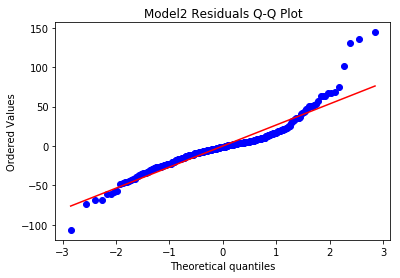

In [41]:
stats.probplot(model2.resid, dist="norm", plot= plt)
plt.title("Model2 Residuals Q-Q Plot")

엄밀히 정규성을 따른다고 말하기 어렵지만, 데이터 갯수(317)가 크니 중심극한정리(CLT)에 의해 정규분포를 따른다고 가정하겠음

### 2) 등분산

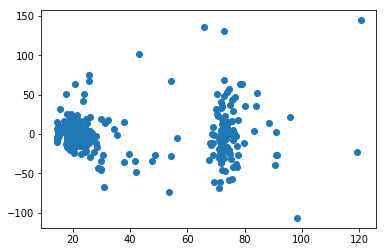

In [42]:
resid = model2.resid
plt.scatter(model2.predict(), resid)

In [43]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model2.resid, model2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 96.16961579163242),
 ('p-value', 6.426586584361543e-20),
 ('f-value', 33.96828773648032),
 ('f p-value', 1.556382958244717e-23)]

p-value < 0.05 이므로 등분산 가정도 만족을 안 한다..

### 3) 오차의 독립성

In [44]:
statsmodels.stats.stattools.durbin_watson(model2.resid)

2.091845997408242

2에 가까울수록 독립성 가정이 만족하는데, 2에 가까우니 독립성 가정도 만족

## 2. 회귀분석 결과

In [45]:
#model2 = smf.ols("증가 ~ 방송_생생정보 + 방송_수요미식회 + 방영전 + 서울_1",  data=reg).fit(cov_type='HC0')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     48.30
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           1.35e-31
Time:                        12:51:47   Log-Likelihood:                -1507.1
No. Observations:                 317   AIC:                             3024.
Df Residuals:                     312   BIC:                             3043.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3407      3.726      3.849      0.000       7.038      21.643
방송_생생정보        4.5905      2.996      1.532      0.125      -1.282      10.463
방송_수요미식회      53.1939      4.325     12.298      0.000      44.717      61.671
방영전            0.1600      0.082      1.945      0.052      -0.001       0.321
서울_1           3.4289      2.989      1.147      0.251      -2.430       9.288
==============================================================================
Omnibus:                       96.312   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              506.521
Skew:                           1.148   Prob(JB):                    1.02e-110
Kurtosis:                       8.751   Cond. No.                         236.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

F-statstic의 p-value < 0.05 이므로 회귀모형이 유의함

**방영 후 포스팅 증감 = 14.3407 + 4.5905(생생정보통) + 53.1939(수요미식회) + 0.16(방영전) + 3.4289(서울_1)**

**해석**

1. 생생정보통이 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 4.5905개 더 많다.

**2. 수요미식회가 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 53.1939개 더 많다.**

3. 방영전 포스팅이 1개 증가하면 방영후 포스팅이 0.16개 더 증가한다.

4. 서울에 위치한 식당이 그렇지 않은 식당보다 방영 후 포스팅 증가분이 3.4289이 더 많다.

**5. R^2 = 0.462 : 방송 프로그램, 방영전 포스팅 갯수 변수들의 분산이 방영후 포스팅 증가분의 분산을 46.2% 정도 설명한다. 즉, 모형의 설명력이 46.2% 된다고 해석할 수 있다. 서울 변수를 추가했더니 0.2% 설명력이 늘었음**


**독립변수의 p-value를 봤을 때, 통계적으로 유의한 변수는 수요미식회뿐... 서울 여부 변수를 추가했는데 유의한 변수가 아니었음**

## 계절 변수 추가 : 증가(y) ~ 방송_생생정보(x1) + 방송_수요미식회(x2) + 방영전(x3) + 계절_여름(x4) + 계절_가을(x5) + 계절_겨울(x6)

In [46]:
model3 = smf.ols("증가 ~ 방송_생생정보 + 방송_수요미식회 + 방영전 + 계절_여름 + 계절_가을 + 계절_겨울",  data=reg).fit(cov_type='HC0')

In [50]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     33.12
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           8.66e-31
Time:                        14:36:12   Log-Likelihood:                -1505.7
No. Observations:                 317   AIC:                             3025.
Df Residuals:                     310   BIC:                             3052.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.1117      3.197      6.292      0.000      13.847      26.377
방송_생생정보        3.7480      2.983      1.257      0.209      -2.098       9.594
방송_수요미식회      53.7501      4.370     12.301      0.000      45.186      62.315
방영전            0.1635      0.081      2.024      0.043       0.005       0.322
계절_여름         -6.8170      3.862     -1.765      0.078     -14.386       0.752
계절_가을         -7.5058      4.742     -1.583      0.113     -16.799       1.787
계절_겨울         -3.2874      3.994     -0.823      0.410     -11.115       4.540
==============================================================================
Omnibus:                       96.377   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.703
Skew:                           1.155   Prob(JB):                    5.11e-109
Kurtosis:                       8.694   Cond. No.                         263.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### 1. 가정

#### 1) 정규성
- Prob(JB) < 0.05 이므로 정규성 만족 x

#### 2) 등분산
- Prob(Omnibus) < 0.05이므로 등분산도 만족 x..

#### 3) 독립성
- Durbin-Watson = 2.082 : 2에 가까우므로 독립은 만족

### 2. 회귀분석 결과

F-statstic의 p-value < 0.05 이므로 회귀모형이 유의함

**방영 후 포스팅 증감 = 20.1117 + 3.7480(생생정보통) + 53.7501(수요미식회) + 0.1635(방영전) - 6.8170(계절_여름) -7.5058(계절_가을) 
                         -3.2874(계절_겨울)**

**해석**

1. 생생정보통이 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 3.7480개 더 많다.

**2. 수요미식회가 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 53.7501개 더 많다.**

**3. 방영전 포스팅이 1개 증가하면 방영후 포스팅이 0.1635개 더 증가한다.**

4. 봄에 방영된 식당이 다른 계절에 방영된 식당보다 방영 후 포스팅 증가분이 더 많다.

**5. R^2 = 0.466 : 방송 프로그램, 방영전 포스팅 갯수 변수들의 분산이 방영후 포스팅 증가분의 분산을 46.6% 정도 설명한다. 즉, 모형의 설명력이 46.2% 된다고 해석할 수 있다. 계절 변수를 추가했더니 0.6% 설명력이 늘었음**


**독립변수의 p-value를 봤을 때, 통계적으로 유의한 변수는 '수요미식회'와 '방영전 포스팅 갯수'뿐... 계절 변수를 추가했는데 유의한 변수가 아니었음(대신 방영전 변수가 통계적으로 유의하게 됨)**

## 서울, 계절 변수 추가 : 증가(y) ~ 방송_생생정보(x1) + 방송_수요미식회(x2) + 방영전(x3) + 계절_여름(x4) + 계절_가을(x5) + 계절_겨울(x6) + 서울_1(x7)

In [51]:
model4 = smf.ols("증가 ~ 방송_생생정보 + 방송_수요미식회 + 방영전 + 계절_여름 + 계절_가을 + 계절_겨울 + 서울_1",  data=reg).fit(cov_type='HC0')

In [53]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     28.93
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           1.40e-30
Time:                        14:49:12   Log-Likelihood:                -1505.2
No. Observations:                 317   AIC:                             3026.
Df Residuals:                     309   BIC:                             3056.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.9499      3.877      4.630      0.000      10.352      25.548
방송_생생정보        4.7403      3.021      1.569      0.117      -1.180      10.661
방송_수요미식회      53.2231      4.352     12.229      0.000      44.693      61.753
방영전            0.1636      0.081      2.024      0.043       0.005       0.322
계절_여름         -7.0785      3.897     -1.816      0.069     -14.716       0.559
계절_가을         -7.3920      4.739     -1.560      0.119     -16.680       1.896
계절_겨울         -3.6171      4.018     -0.900      0.368     -11.493       4.259
서울_1           3.4830      3.026      1.151      0.250      -2.448       9.414
==============================================================================
Omnibus:                       94.779   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.913
Skew:                           1.138   Prob(JB):                    1.37e-105
Kurtosis:                       8.602   Cond. No.                         268.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### 1. 가정

#### 1) 정규성
- Prob(JB) < 0.05 이므로 정규성 만족 x

#### 2) 등분산
- Prob(Omnibus) < 0.05이므로 등분산도 만족 x..

#### 3) 독립성
- Durbin-Watson = 2.076 : 2에 가까우므로 독립은 만족

### 2. 회귀분석 결과

F-statstic의 p-value < 0.05 이므로 회귀모형이 유의함

**방영 후 포스팅 증감 = 17.9499 + 4.7403(생생정보통) + 53.2231(수요미식회) + 0.1636(방영전) - 7.0785(계절_여름) - 7.3920(계절_가을) 
                         - 3.6171(계절_겨울) + 3.4830(서울_1)**

**해석**

1. 생생정보통이 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 4.7403개 더 많다.

**2. 수요미식회가 맛있는 녀석들보다 방영후 포스팅 증가분이 평균 53.2231개 더 많다.**

**3. 방영전 포스팅이 1개 증가하면 방영후 포스팅이 0.1636개 더 증가한다.**

4. 봄에 방영된 식당이 다른 계절에 방영된 식당보다 방영 후 포스팅 증가분이 더 많다.

5. 서울에 위치한 식당이 그렇지 않은 식당보다 방영 후 포스팅 증가분이 3.4830이 더 많다.

**6. R^2 = 0.468 : 방송 프로그램, 방영전 포스팅 갯수 변수들의 분산이 방영후 포스팅 증가분의 분산을 46.8% 정도 설명한다. 즉, 모형의 설명력이 46.8% 된다고 해석할 수 있다. 계절 변수를 추가했더니 0.8% 설명력이 늘었음**


**독립변수의 p-value를 봤을 때, 통계적으로 유의한 변수는 '수요미식회'와 '방영전 포스팅 갯수'뿐... 계절과 서울 변수를 추가했는데 유의한 변수가 아니었음(대신 방영전 변수가 통계적으로 유의하게 됨)**